# Population by commune

In [1]:
from pynsee.geodata import *

import math
import geopandas as gpd
import pandas as pd
from pandas.api.types import CategoricalDtype
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import descartes

In [2]:
# get geographical data list
geodata_list = get_geodata_list()
# get departments geographical limits
com = get_geodata('ADMINEXPRESS-COG-CARTO.LATEST:commune')

Previously saved data used
/home/jovyan/.cache/pynsee/pynsee/2ac583be54e866b2b1b30fb0113c1fd0.csv
Set update=True to get the most up-to-date data
Previously saved data used
/home/jovyan/.cache/pynsee/pynsee/a4f589755961ab3aa6bdff99605334d1
Set update=True to get the most up-to-date data


In [3]:
mapcom = gpd.GeoDataFrame(com).set_crs("EPSG:3857")

mapcom = mapcom.to_crs(epsg=3035)
mapcom["area"] = mapcom['geometry'].area / 10**6
mapcom = mapcom.to_crs(epsg=3857)

mapcom['REF_AREA'] = 'D' + mapcom['insee_dep']
mapcom['density'] = mapcom['population'] / mapcom['area'] 

mapcom = GeoDataframe(mapcom)
mapcom = mapcom.translate(departement = ['971', '972', '974', '973', '976'], 
                          factors = [1.5, 1.5, 1.5, 0.35, 1.5])

mapcom = mapcom.zoom(departement = ["75","92", "93", "91", "77", "78", "95", "94"],
                     factor=1.5, angle = math.pi * (1 - 3 * 1/9))
mapcom

/opt/conda/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1990: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  result[:] = values
/opt/conda/lib/python3.9/site-packages/pandas/core/dtypes/inference.py:383: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  iter(obj)  # Can iterate over it.
/opt/conda/lib/python3.9/site-packages/pandas/core/dtypes/inference.py:384: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  len(obj)  # Has a length associated with it.
/opt/conda/lib/python3.9/site-packages/pandas/i

,id,nom,nom_m,insee_com,statut,population,insee_can,insee_arr,insee_dep,insee_reg,siren_epci,geometry,bbox,crs,area,REF_AREA,density
0,COMMUNE_0000001169858680,Basse-Terre,BASSE-TERRE,97105,Préfecture de région,10046,06,1,971,01,249710070,(POLYGON ((-750724.8169219699 6268681.73061257...,"[-6873564.10795631, 1803062.14507434, -6869802...",EPSG:3857,4.472072,D971,2246.386181
1,COMMUNE_0000001169858692,Capesterre-de-Marie-Galante,CAPESTERRE-DE-MARIE-GALANTE,97108,Commune simple,3293,10,2,971,01,249710047,(POLYGON ((-666227.3979513757 6260492.33968821...,"[-6819904.02215333, 1789762.25363456, -6812187...",EPSG:3857,46.124250,D971,71.394115
2,COMMUNE_0000001169858684,Capesterre-Belle-Eau,CAPESTERRE-BELLE-EAU,97107,Commune simple,18131,07,1,971,01,249710070,(POLYGON ((-742954.5199814234 6282205.68457379...,"[-6866643.13408756, 1803123.47210352, -6852304...",EPSG:3857,103.037919,D971,175.964346
3,COMMUNE_0000001169858693,Grand-Bourg,GRAND-BOURG,97112,Commune simple,4941,10,2,971,01,249710047,(POLYGON ((-672845.8520800807 6253496.59520272...,"[-6828023.67152086, 1789268.22423606, -6818156...",EPSG:3857,55.517438,D971,88.999063
4,COMMUNE_0000001169858696,Terre-de-Haut,TERRE-DE-HAUT,97131,Commune simple,1526,20,1,971,01,249710070,(POLYGON ((-726690.7697543278 6238652.94046583...,"[-6858639.40438449, 1785277.73400778, -6853475...",EPSG:3857,5.789278,D971,263.590706
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36228,COMMUNE_0000000009734468,Vendrest,VENDREST,77490,Commune simple,713,06,1,77,11,247700065,(POLYGON ((-361891.4578667551 6622609.17197233...,"[341330.98775089, 6278825.84895588, 350904.847...",EPSG:3857,17.692283,D77,40.300056
36229,COMMUNE_0000000009734980,Ocquerre,OCQUERRE,77343,Commune simple,410,06,1,77,11,247700065,(POLYGON ((-364995.76858822466 6618752.6345492...,"[337038.06572493, 6277160.42905055, 343734.463...",EPSG:3857,10.165914,D77,40.330855
36230,COMMUNE_0000000009734471,Crouy-sur-Ourcq,CROUY-SUR-OURCQ,77148,Commune simple,1869,06,1,77,11,247700065,(POLYGON ((-356443.6162894644 6642239.98292819...,"[338921.96386096, 6283813.30797406, 347069.547...",EPSG:3857,19.419044,D77,96.245725
36231,COMMUNE_0000000009734981,Mary-sur-Marne,MARY-SUR-MARNE,77280,Commune simple,1132,06,1,77,11,247700065,(POLYGON ((-373298.82447945024 6618451.9694665...,"[335409.61945441, 6276030.38893351, 339858.746...",EPSG:3857,2.233051,D77,506.929766


In [4]:
mapplot = gpd.GeoDataFrame(mapcom)
mapplot.loc[mapplot.density < 40, 'range'] = "< 40"
mapplot.loc[mapplot.density >= 20000, 'range'] = "> 20 000"

density_ranges = [40, 80, 100, 120, 150, 200, 250, 400, 600, 1000, 2000, 5000, 10000, 20000]
list_ranges = []
list_ranges.append( "< 40")

for i in range(len(density_ranges)-1):
    min_range = density_ranges[i]
    max_range = density_ranges[i+1]
    range_string = "[{}, {}[".format(min_range, max_range)
    mapplot.loc[(mapplot.density >= min_range) & (mapplot.density < max_range), 'range'] = range_string
    list_ranges.append(range_string)

list_ranges.append("> 20 000")

mapplot['range'] = mapplot['range'].astype(CategoricalDtype(categories=list_ranges, ordered=True))  

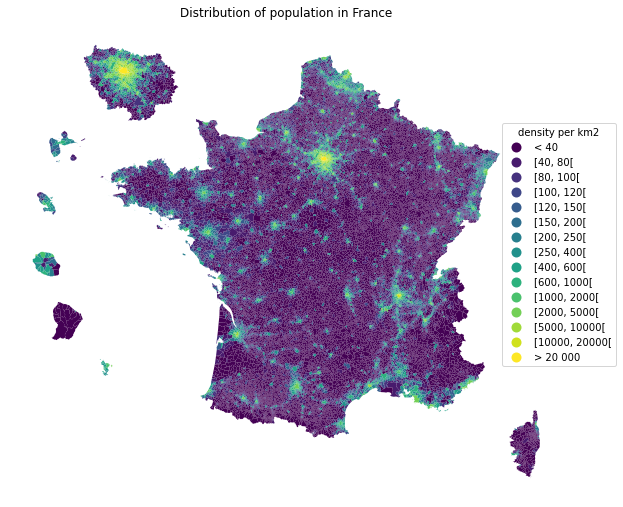

In [5]:
fig, ax = plt.subplots(1,1,figsize=[10,10])
mapplot.plot(column='range', cmap=cm.viridis,
    legend=True, ax=ax,
    legend_kwds={'bbox_to_anchor': (1.1, 0.8),
                 'title':'density per km2'})
ax.set_axis_off()
ax.set(title='Distribution of population in France')
plt.show()

fig.savefig('pop_france.svg',
            format='svg', dpi=1200,
            bbox_inches = 'tight',
            pad_inches = 0)